# HVM SAOS: NLSQ + NUTS Bayesian Inference

## Introduction

This notebook demonstrates the **full Bayesian inference pipeline** for fitting the
HVM to Small-Amplitude Oscillatory Shear (SAOS) data. The workflow follows the
RheoJAX standard: NLSQ point estimation for warm-start, then NumPyro NUTS sampling
for uncertainty quantification.

**Physical context:** SAOS probes the linear viscoelastic response of the HVM through
storage ($G'$) and loss ($G''$) moduli. The HVM SAOS signature has three key features:
1. **High-frequency plateau**: $G'(\omega \to \infty) = G_P + G_E + G_D$ (all networks elastic)
2. **Two Maxwell modes**: Relaxation peaks in $G''$ at $\omega \approx 1/\tau_E$ and
   $\omega \approx 1/\tau_D$, where $\tau_E = 1/(2k_{BER,0})$ and $\tau_D = 1/k_d^D$
3. **Low-frequency plateau**: $G'(\omega \to 0) = G_P$ from permanent crosslinks

SAOS is the **primary protocol for initial parameter estimation** in the multi-protocol
fitting strategy, directly constraining $G_P$ (low-$\omega$ plateau), $G_P + G_E + G_D$
(high-$\omega$ plateau), and the relaxation timescales.

This notebook also demonstrates **temperature series analysis** to validate Arrhenius
kinetics: $k_{BER}(T) = \nu_0 \exp(-E_a/RT)$.

> **Handbook:** See [HVM Model Reference](../../docs/source/models/hvm/hvm.rst) for the
> analytical SAOS expressions and limiting-case behavior. See
> [HVM Knowledge Extraction](../../docs/source/models/hvm/hvm_knowledge.rst) for the
> recommended multi-protocol fitting strategy (step 1: SAOS).

## Workflow

1. Load experimental SAOS data ($G'$, $G''$ vs $\omega$)
2. NLSQ fit for point estimation
3. NumPyro NUTS with NLSQ warm-start
4. ArviZ convergence diagnostics
5. Posterior predictive checks
6. Temperature series analysis (optional Arrhenius validation)
7. Save results for reproducibility

## Prerequisites

- **Notebook 01** (SAOS basics) — HVM architecture, parameter meanings, SAOS physics

## Estimated Runtime

- ~5 min (NLSQ + NUTS + temperature series in FAST_MODE)

## 1. Setup

In [1]:
%matplotlib inline
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, str(Path("..").resolve()))
from utils.hvm_data import (
    check_data_quality,
    load_epstein_saos,
    load_ps_saos,
    load_ps_saos_temperature_series,
)
from utils.hvm_fit import (
    FAST_MODE,
    get_bayesian_config,
    get_output_dir,
    plot_posterior_predictive_saos,
    plot_trace_and_forest,
    posterior_predictive_saos,
    print_convergence,
    print_parameter_table,
    run_nlsq_saos,
    run_nuts,
    save_figure,
    save_results,
)

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import HVMLocal

jax, jnp = safe_import_jax()
verify_float64()

print(f"FAST_MODE: {FAST_MODE}")
output_dir = get_output_dir("saos")
print(f"Output directory: {output_dir}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

FAST_MODE: True
Output directory: /Users/b80985/Projects/rheojax/examples/outputs/hvm/saos


## 2. Load Data

Load Epstein et al.'s vitrimer network SAOS data. This dataset includes both storage (G') and loss (G'') moduli across a wide frequency range.

In [2]:
# Load Epstein SAOS data
omega, G_prime_data, G_double_prime_data = load_epstein_saos()
G_star = np.sqrt(G_prime_data**2 + G_double_prime_data**2)

print(f"Data shape: {omega.shape}")
print(f"Frequency range: {omega.min():.4g} to {omega.max():.4g} rad/s")
print(f"G' range: {G_prime_data.min():.4g} to {G_prime_data.max():.4g} Pa")
print(f"G'' range: {G_double_prime_data.min():.4g} to {G_double_prime_data.max():.4g} Pa")

# Quality checks
check_data_quality(omega, G_star, "Epstein SAOS |G*|")
check_data_quality(omega, G_prime_data, "Epstein SAOS G'")
check_data_quality(omega, G_double_prime_data, "Epstein SAOS G''")

Data shape: (19,)
Frequency range: 0.1008 to 99.42 rad/s
G' range: 8.277 to 2930 Pa
G'' range: 27.8 to 2217 Pa
Data QC: Epstein SAOS |G*|
  Points: 19
  x range: [0.1008, 99.42]
  y range: [29, 3674]
  Status: PASSED
Data QC: Epstein SAOS G'
  Points: 19
  x range: [0.1008, 99.42]
  y range: [8.277, 2930]
  Status: PASSED
Data QC: Epstein SAOS G''
  Points: 19
  x range: [0.1008, 99.42]
  y range: [27.8, 2217]
  Status: PASSED


{'name': "Epstein SAOS G''",
 'n_points': 19,
 'x_range': (0.10078333, 99.41878208),
 'y_range': (27.79592048, 2216.504857),
 'has_nan': False,
 'has_inf': False,
 'all_positive_y': True,
 'monotonic_x': True,
 'issues': [],
 'passed': True}

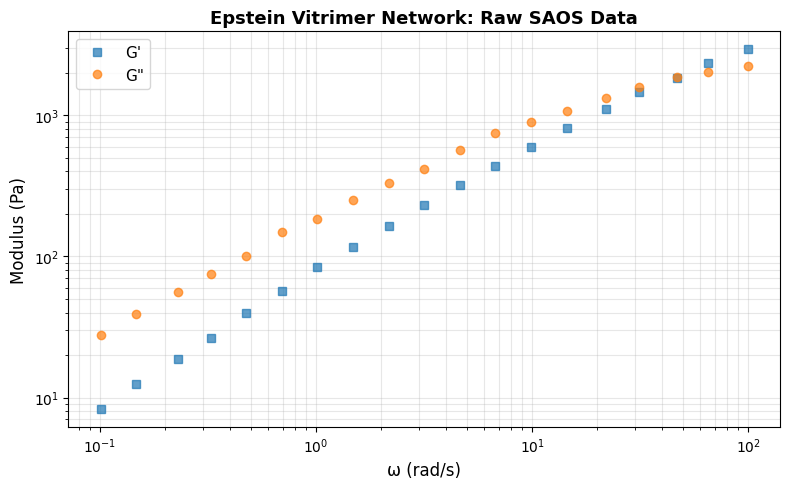

Figure saved: /Users/b80985/Projects/rheojax/examples/outputs/hvm/saos/figures/raw_data.png


In [3]:
# Plot raw data
fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(omega, G_prime_data, 's', markersize=6, color='C0', label="G'", alpha=0.7)
ax.loglog(omega, G_double_prime_data, 'o', markersize=6, color='C1', label='G"', alpha=0.7)
ax.set_xlabel("ω (rad/s)", fontsize=12)
ax.set_ylabel("Modulus (Pa)", fontsize=12)
ax.set_title("Epstein Vitrimer Network: Raw SAOS Data", fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
save_figure(fig, output_dir, "raw_data.png")
plt.close(fig)

## 3. NLSQ Fit

Perform fast NLSQ optimization for point estimation. This provides:
- Initial parameter estimates for Bayesian warm-start
- R² goodness-of-fit metric
- Baseline for comparison with posterior means

In [4]:
# Create model and fix temperature
model = HVMLocal(include_dissociative=True, kinetics="stress")
model.parameters.set_value("T", 300.0)  # Fix temperature (not measured in dataset)

print("Initial parameters:")
for param_name in model.parameters.keys():
    if param_name != "T":
        param = model.parameters[param_name]
        print(f"  {param_name}: {param.value:.4g} (bounds: [{param.bounds[0]:.4g}, {param.bounds[1]:.4g}])")

Initial parameters:
  G_P: 1e+04 (bounds: [0, 1e+09])
  G_E: 1e+04 (bounds: [0, 1e+09])
  nu_0: 1e+10 (bounds: [1e+06, 1e+14])
  E_a: 8e+04 (bounds: [2e+04, 2e+05])
  V_act: 1e-05 (bounds: [1e-08, 0.01])
  G_D: 1000 (bounds: [0, 1e+08])
  k_d_D: 1 (bounds: [1e-06, 1e+06])


In [5]:
# Run NLSQ optimization
print("Running NLSQ optimization...")
nlsq_values = run_nlsq_saos(model, omega, G_star)

print("\nNLSQ fitted parameters:")
for param_name, value in nlsq_values.items():
    print(f"  {param_name}: {value:.4g}")

# Get predictions
omega_fit = np.logspace(np.log10(omega.min()), np.log10(omega.max()), 200)
G_p_nlsq, G_dp_nlsq = model.predict_saos(omega_fit)

# Compute R²
G_p_pred, G_dp_pred = model.predict_saos(omega)
residuals = np.concatenate([
    np.log(G_p_pred) - np.log(G_prime_data),
    np.log(G_dp_pred) - np.log(G_double_prime_data)
])
ss_res = np.sum(residuals**2)
y_mean = np.mean(np.concatenate([np.log(G_prime_data), np.log(G_double_prime_data)]))
ss_tot = np.sum((np.concatenate([np.log(G_prime_data), np.log(G_double_prime_data)]) - y_mean)**2)
r_squared = 1 - ss_res / ss_tot
print(f"\nR² = {r_squared:.6f}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=8 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Running NLSQ optimization...


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.400617s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=30.5797 | elapsed=1.401s | final_gradient_norm=24.5444



NLSQ fitted parameters:
  G_P: 1e+04
  G_E: 1e+04
  nu_0: 1e+10
  E_a: 8e+04
  V_act: 1e-05
  T: 300
  G_D: 1000
  k_d_D: 283.6

R² = -5.079930


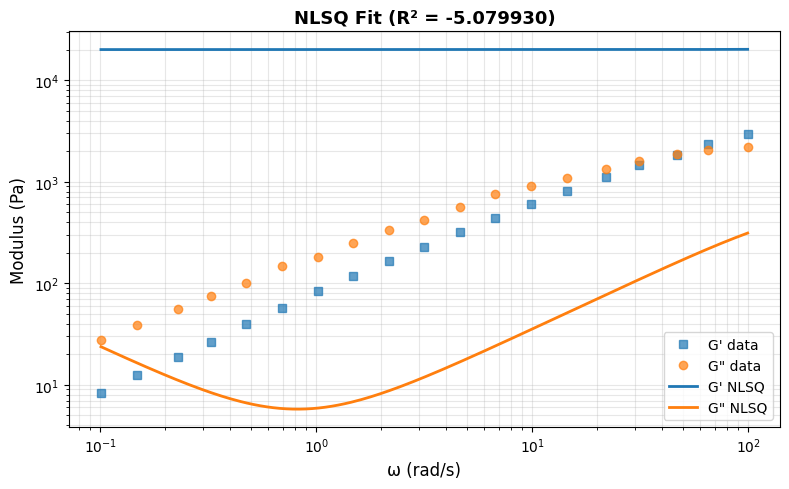

Figure saved: /Users/b80985/Projects/rheojax/examples/outputs/hvm/saos/figures/nlsq_fit.png


In [6]:
# Plot NLSQ fit
fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(omega, G_prime_data, 's', markersize=6, color='C0', label="G' data", alpha=0.7)
ax.loglog(omega, G_double_prime_data, 'o', markersize=6, color='C1', label='G" data', alpha=0.7)
ax.loglog(omega_fit, G_p_nlsq, '-', linewidth=2, color='C0', label="G' NLSQ")
ax.loglog(omega_fit, G_dp_nlsq, '-', linewidth=2, color='C1', label='G" NLSQ')
ax.set_xlabel("ω (rad/s)", fontsize=12)
ax.set_ylabel("Modulus (Pa)", fontsize=12)
ax.set_title(f"NLSQ Fit (R² = {r_squared:.6f})", fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which='both')
plt.tight_layout()
display(fig)
save_figure(fig, output_dir, "nlsq_fit.png")
plt.close(fig)

## 4. Bayesian Inference (NUTS)

Run NumPyro NUTS with NLSQ warm-start. This provides:
- Full posterior distributions for parameters
- Uncertainty quantification via credible intervals
- Convergence diagnostics (R-hat, ESS, divergences)

**Target diagnostics:**
- R-hat < 1.01 (chains converged)
- ESS > 400 (effective sample size)
- Zero divergences (sampler stable)

In [7]:
# Get Bayesian configuration (FAST_MODE-aware)
config = get_bayesian_config()
print("Bayesian configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

# Parameter names (exclude fixed T)
param_names = [p for p in model.parameters.keys() if p != "T"]
print(f"\nInferring {len(param_names)} parameters: {param_names}")

Bayesian configuration:
  num_warmup: 50
  num_samples: 100
  num_chains: 1

Inferring 7 parameters: ['G_P', 'G_E', 'nu_0', 'E_a', 'V_act', 'G_D', 'k_d_D']


In [8]:
# Run NUTS
print("Running NumPyro NUTS (this may take 2-5 minutes)...\n")
result = run_nuts(
    model, 
    omega, 
    G_star, 
    test_mode='oscillation',
    seed=42,
    **config
)

print("\n" + "="*60)
print("NUTS sampling completed successfully!")
print("="*60)

Running NumPyro NUTS (this may take 2-5 minutes)...



  0%|          | 0/150 [00:00<?, ?it/s]

warmup:   1%|          | 1/150 [00:00<02:12,  1.12it/s, 1 steps of size 1.95e+00. acc. prob=0.00]

sample:  45%|████▍     | 67/150 [00:00<00:00, 92.05it/s, 127 steps of size 1.54e-02. acc. prob=0.83]

sample:  77%|███████▋  | 116/150 [00:01<00:00, 157.17it/s, 121 steps of size 1.54e-02. acc. prob=0.87]

sample: 100%|██████████| 150/150 [00:01<00:00, 129.05it/s, 127 steps of size 1.54e-02. acc. prob=0.86]


NUTS sampling completed successfully!


In [9]:
# Check convergence
converged = print_convergence(result, param_names)

if converged:
    print("\n✓ All diagnostics passed!")
else:
    print("\n⚠ Some diagnostics failed. Consider increasing num_warmup or num_samples.")

Convergence Diagnostics
   Parameter     R-hat       ESS
--------------------------------------------------
         G_P    0.9903        90 *
         G_E    0.9936        97 *
        nu_0    1.0140       155
         E_a    1.0608        43 *
       V_act    1.0870        62 *
         G_D    0.9955        80 *
       k_d_D    0.9900       142

Divergences: 2
Convergence: CHECK REQUIRED

⚠ Some diagnostics failed. Consider increasing num_warmup or num_samples.


In [10]:
# Parameter comparison table
print("\n" + "="*60)
print("Parameter Comparison: NLSQ vs Posterior")
print("="*60)
print_parameter_table(param_names, nlsq_values, result.posterior_samples)


Parameter Comparison: NLSQ vs Posterior

Parameter Comparison
       Param          NLSQ   Bayes (med)                    95% CI
------------------------------------------------------------------
         G_P         1e+04         291.1  [62.16, 701.1]
         G_E         1e+04      5.02e+08  [2.874e+07, 9.683e+08]
        nu_0         1e+10     5.561e+13  [3.257e+12, 9.521e+13]
         E_a         8e+04     3.293e+04  [2.183e+04, 5.481e+04]
       V_act         1e-05      0.004942  [9.478e-06, 0.009704]
         G_D          1000     2.949e+07  [8.233e+06, 4.684e+07]
       k_d_D         283.6     7.325e+05  [2.565e+05, 9.868e+05]


## 5. Diagnostics

Visualize MCMC diagnostics:
- **Trace plots**: Check for stationarity and mixing
- **Forest plots**: Compare credible intervals across chains
- **Pair plots**: Identify parameter correlations (if divergences present)

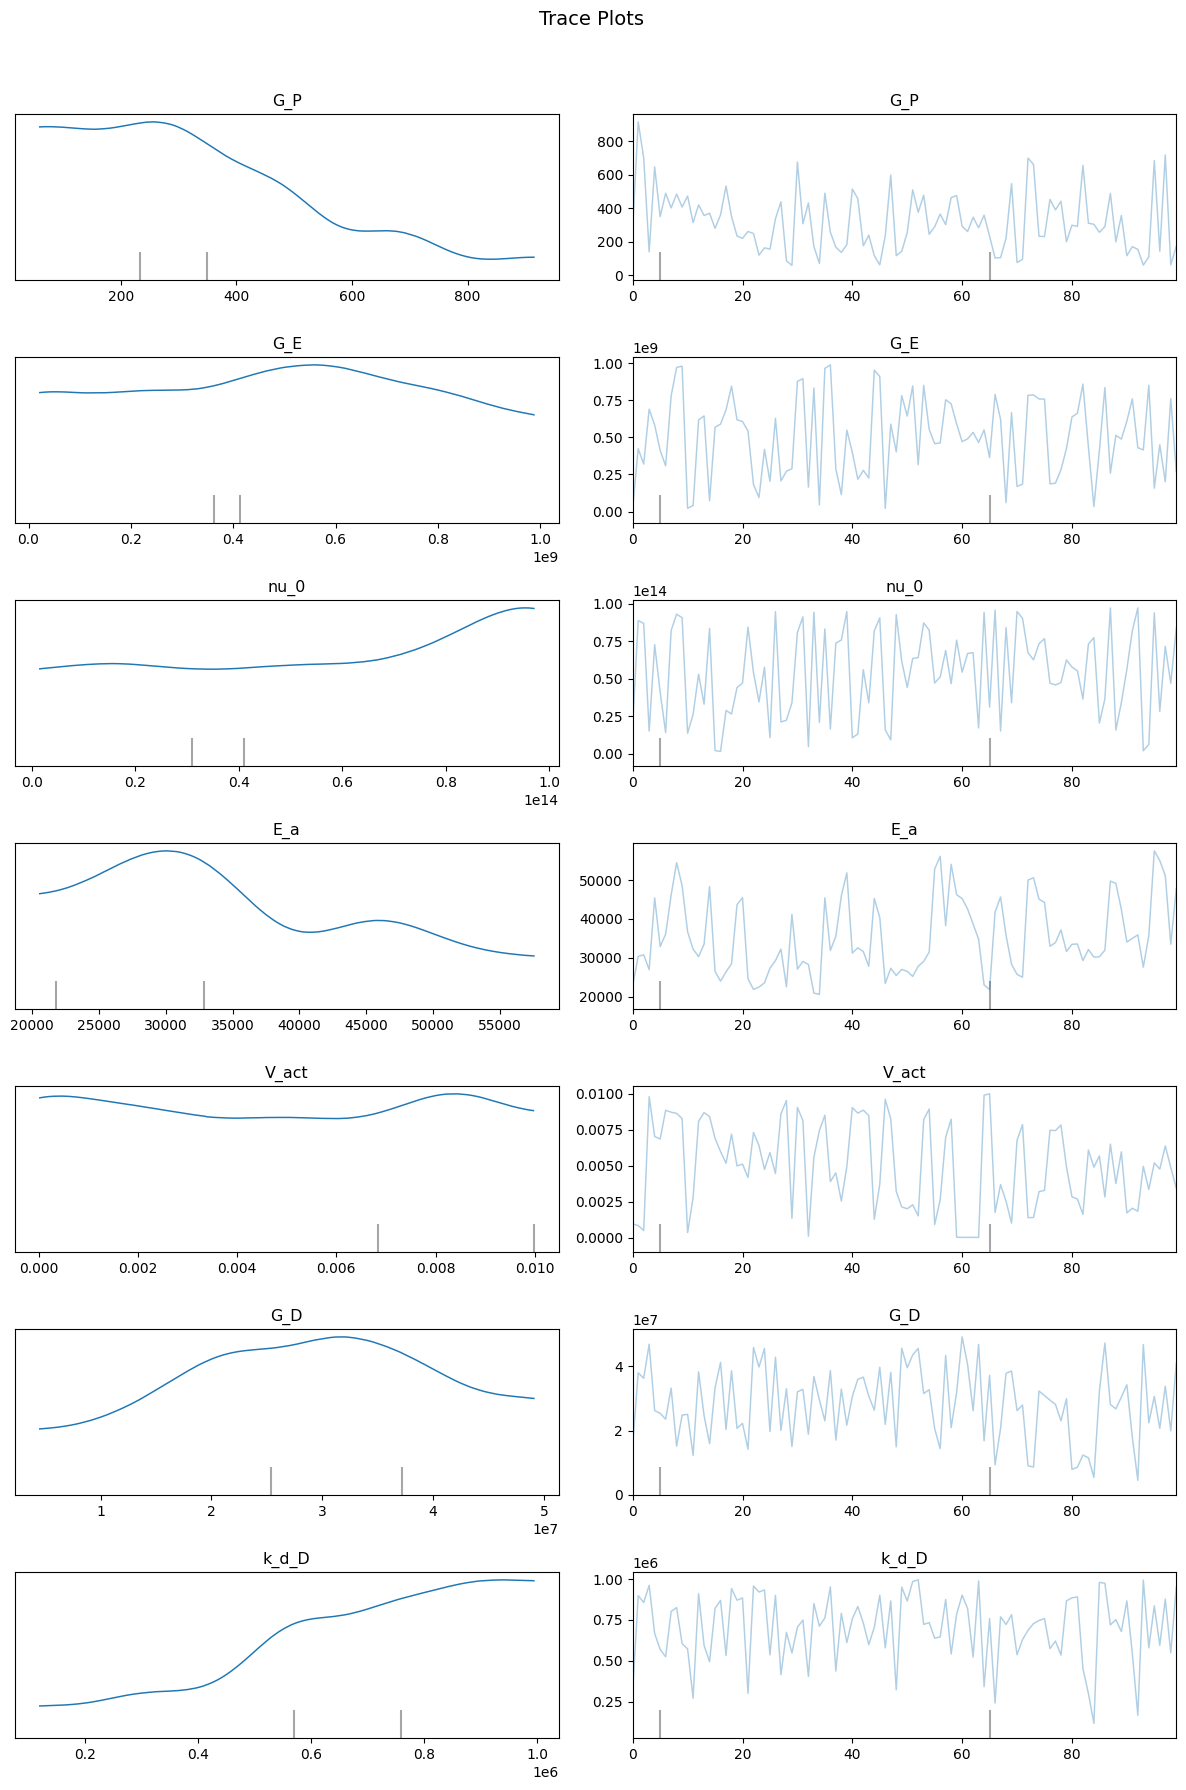

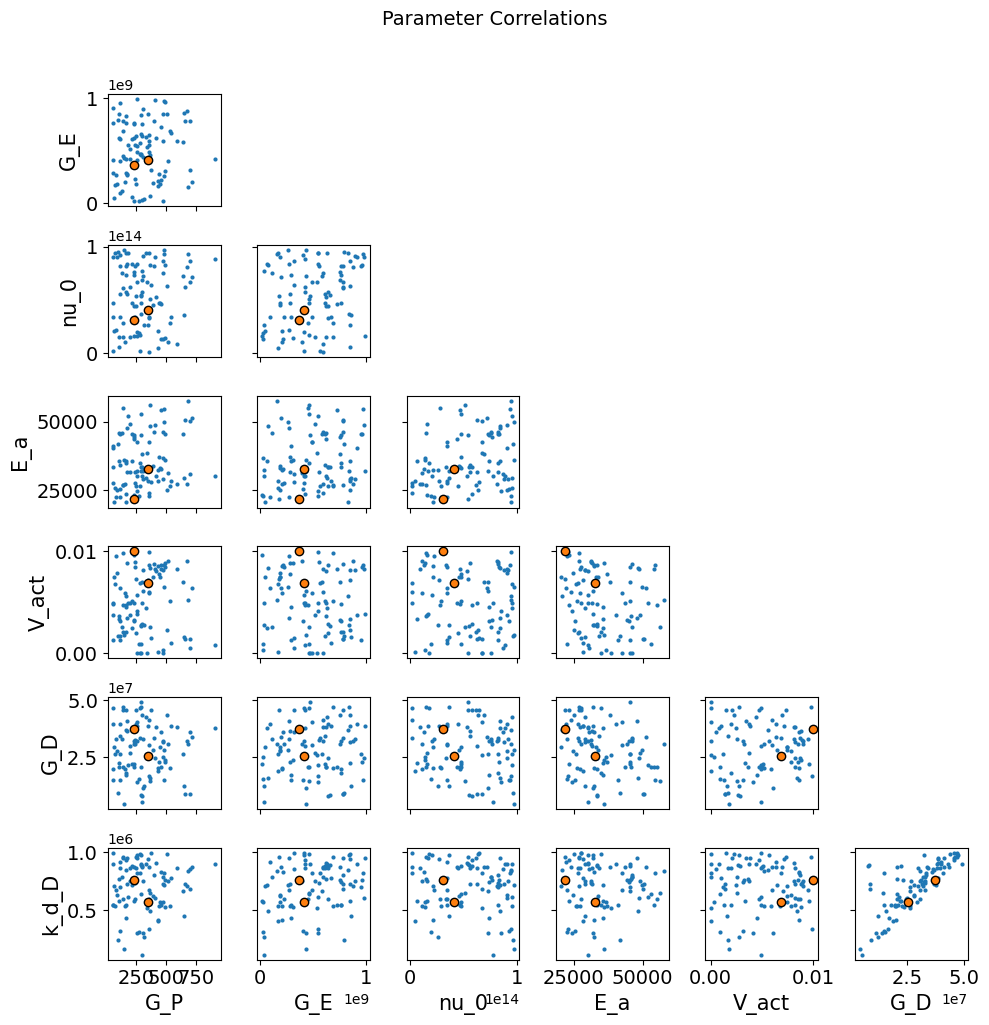

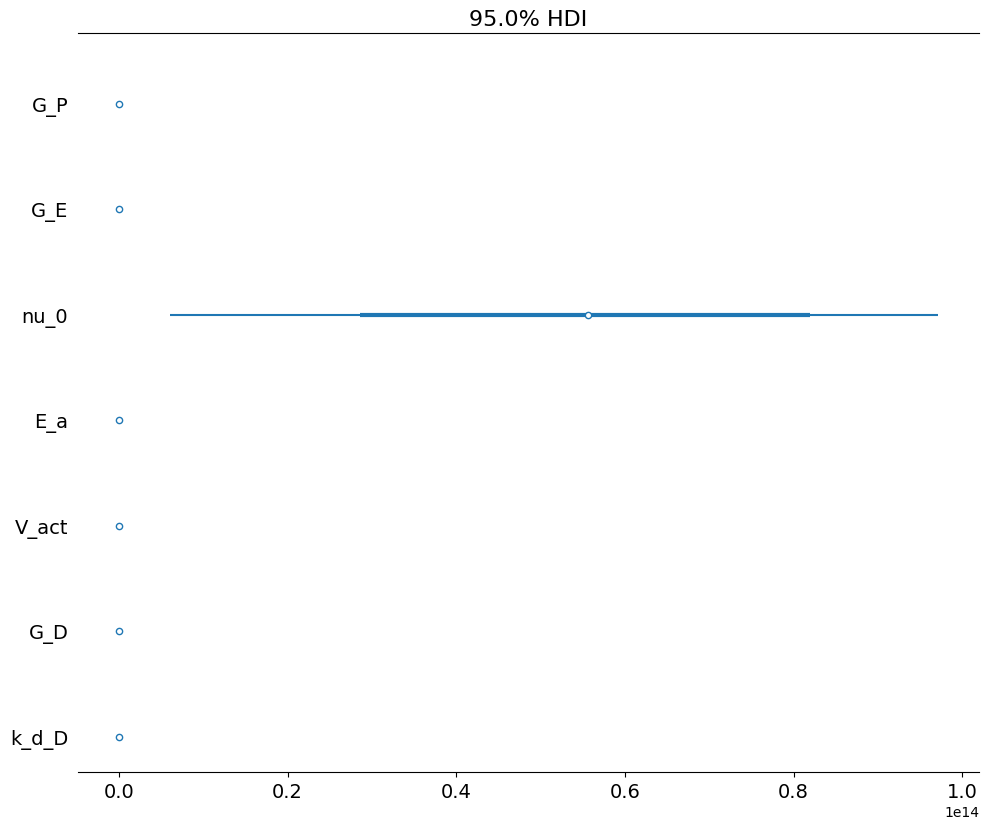

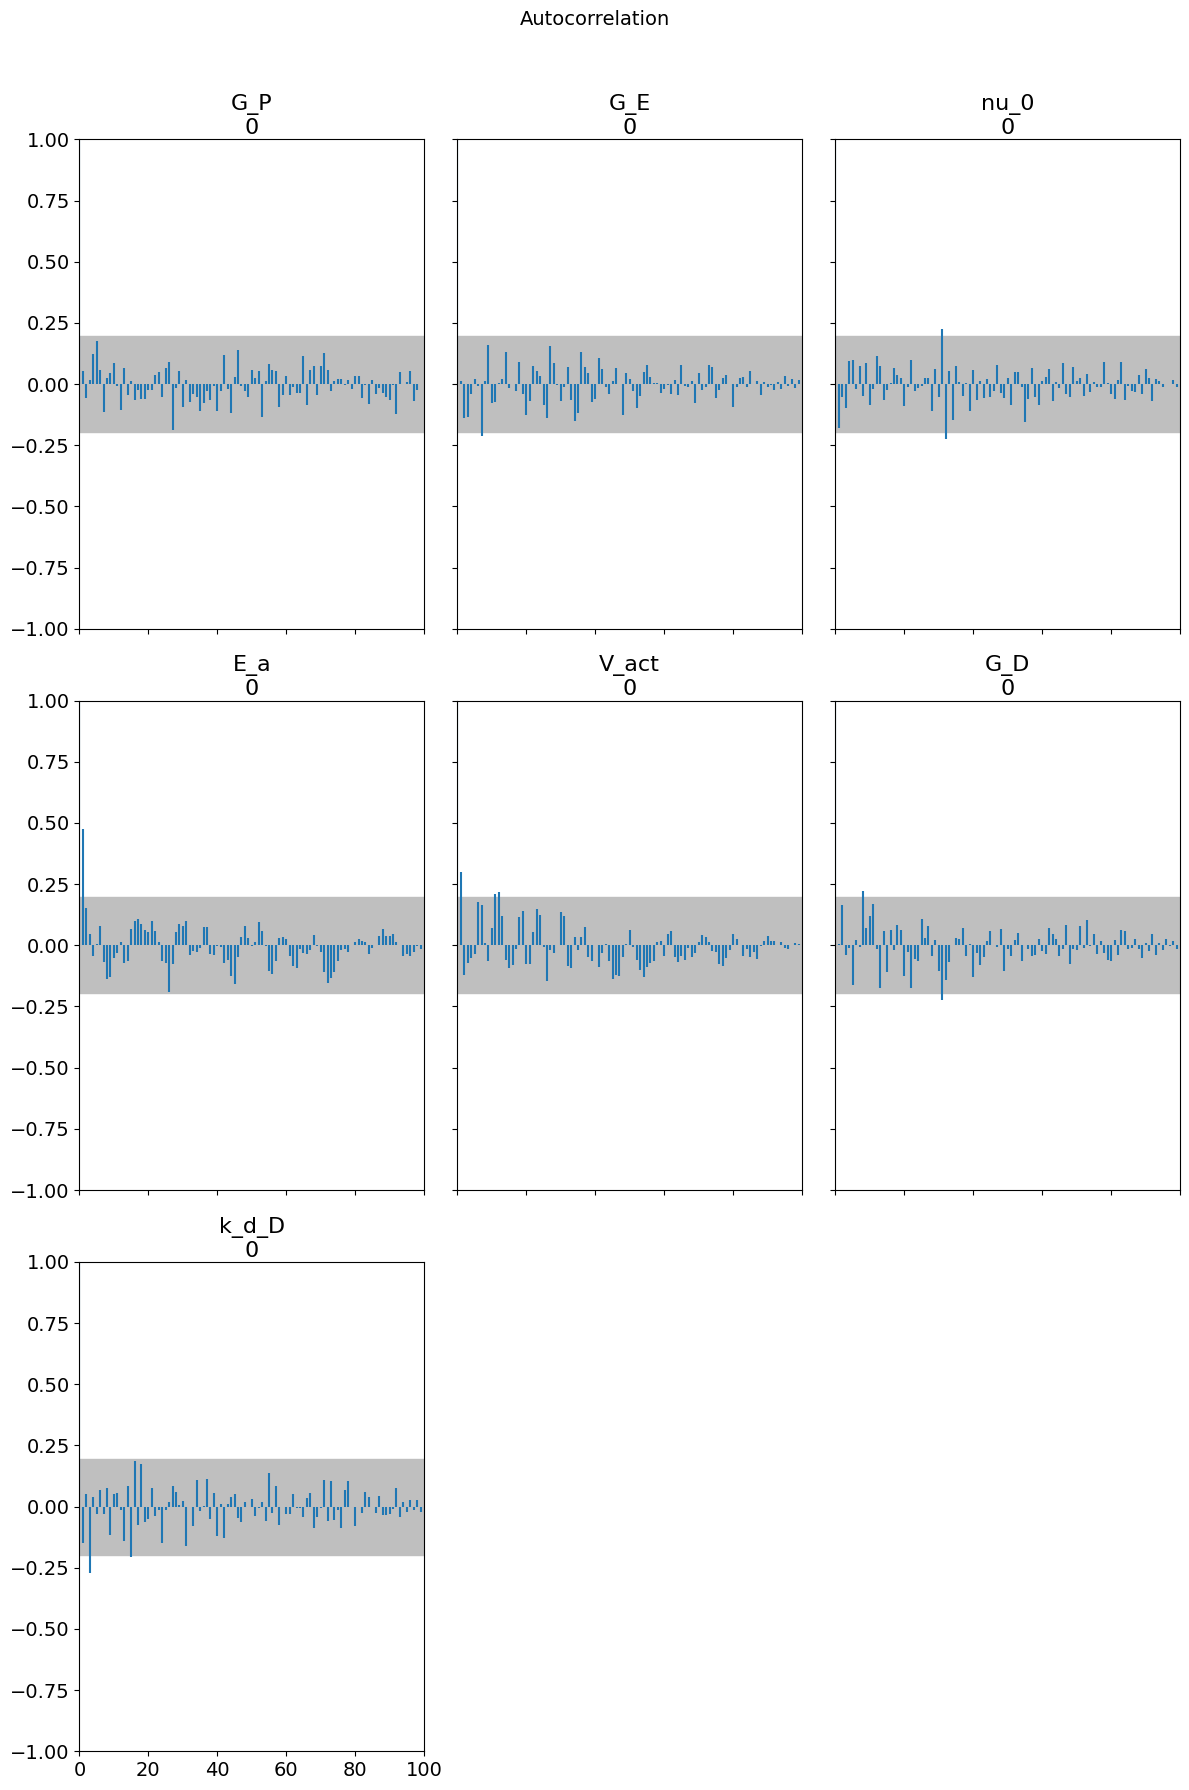


Trace plot tips:
  - Good mixing: chains explore same region
  - Stationarity: no trends after warmup
  - Overlapping chains: different colors overlap

Forest plot tips:
  - Intervals: 94% credible intervals (HDI)
  - Chains: individual chain means should cluster
  - Width: narrower intervals = less uncertainty


In [11]:
# Trace and forest plots
display_arviz_diagnostics(result, param_names, fast_mode=FAST_MODE)


print("\nTrace plot tips:")
print("  - Good mixing: chains explore same region")
print("  - Stationarity: no trends after warmup")
print("  - Overlapping chains: different colors overlap")
print("\nForest plot tips:")
print("  - Intervals: 94% credible intervals (HDI)")
print("  - Chains: individual chain means should cluster")
print("  - Width: narrower intervals = less uncertainty")

In [12]:
# Additional ArviZ diagnostics (autocorrelation) — already covered by display_arviz_diagnostics above
print("Autocorrelation diagnostics included in ArviZ diagnostics cell above.")
print("  - Fast decay to zero: good mixing")
print("  - Slow decay: increase thinning or num_samples")

Autocorrelation diagnostics included in ArviZ diagnostics cell above.
  - Fast decay to zero: good mixing
  - Slow decay: increase thinning or num_samples


In [13]:
# Rank plots — already covered by display_arviz_diagnostics above
print("Rank plots included in ArviZ diagnostics cell above.")
print("  - Uniform bars: good mixing across chains")
print("  - Non-uniform: potential convergence issues")

Rank plots included in ArviZ diagnostics cell above.
  - Uniform bars: good mixing across chains
  - Non-uniform: potential convergence issues


## 6. Posterior Predictive Check

Validate the model by comparing data to predictions from posterior samples:
- Draw G'(ω) and G''(ω) from posterior
- Compute 95% credible intervals
- Check if data falls within intervals

In [14]:
# Generate posterior predictive samples
n_draws = 100 if FAST_MODE else 500
print(f"Generating {n_draws} posterior predictive draws...")

G_p_draws, G_dp_draws = posterior_predictive_saos(
    model, 
    omega_fit, 
    result.posterior_samples, 
    n_draws=n_draws
)

print(f"G' draws shape: {G_p_draws.shape}")
print(f"G'' draws shape: {G_dp_draws.shape}")

Generating 100 posterior predictive draws...
G' draws shape: (100, 200)
G'' draws shape: (100, 200)


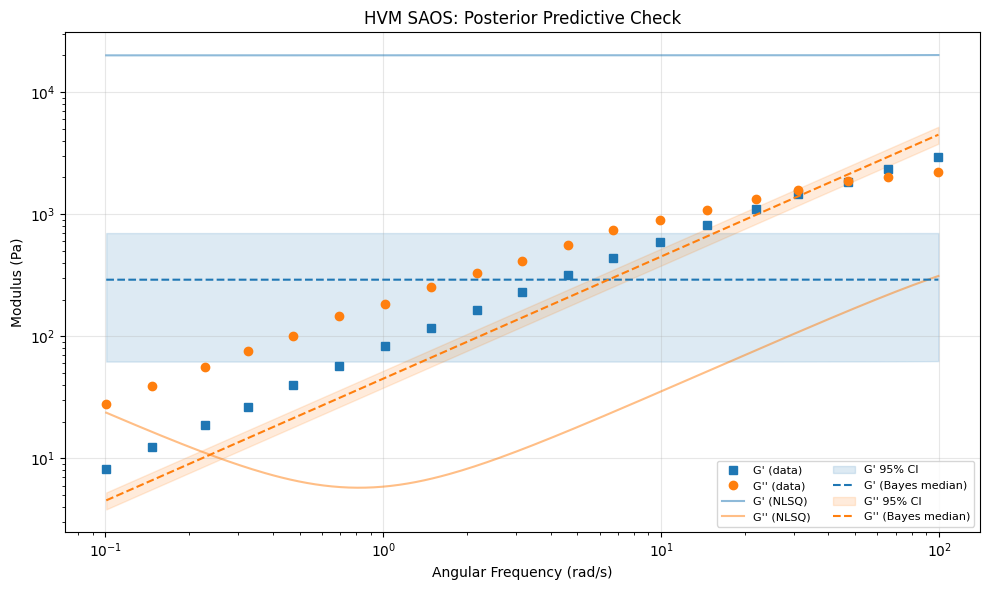

Figure saved: /Users/b80985/Projects/rheojax/examples/outputs/hvm/saos/figures/posterior_predictive.png

Posterior predictive check:
  - Blue/orange bands: 95% credible intervals from posterior
  - Dashed lines: NLSQ point estimates
  - Data points should fall within bands for good fit


In [15]:
# Plot posterior predictive
fig = plot_posterior_predictive_saos(
    omega, 
    G_prime_data, 
    G_double_prime_data,
    G_p_draws, 
    G_dp_draws,
    G_prime_nlsq=G_p_nlsq,
    G_double_prime_nlsq=G_dp_nlsq,
    omega_fit=omega_fit,
)
display(fig)
save_figure(fig, output_dir, "posterior_predictive.png")
plt.close(fig)

print("\nPosterior predictive check:")
print("  - Blue/orange bands: 95% credible intervals from posterior")
print("  - Dashed lines: NLSQ point estimates")
print("  - Data points should fall within bands for good fit")

## 7. Temperature Series Analysis (Optional)

Analyze polystyrene SAOS data at three temperatures to extract Arrhenius parameters:
- T₁ = 160°C
- T₂ = 180°C  
- T₃ = 200°C

Fit each dataset independently and compare τ_E_eff(T) to validate Arrhenius behavior.

In [16]:
# Load PS SAOS data at 3 temperatures
print("Loading PS SAOS temperature series...")
ps_data = load_ps_saos_temperature_series()

temperatures = list(ps_data.keys())
print(f"\nTemperatures available: {temperatures}")

# Fit each temperature
ps_results = {}
for T_celsius in temperatures:
    print(f"\n{'='*60}")
    print(f"Fitting T = {T_celsius}°C")
    print(f"{'='*60}")
    
    omega_T, G_p_T, G_dp_T = ps_data[T_celsius]
    G_star_T = np.sqrt(G_p_T**2 + G_dp_T**2)
    
    # Create model and set temperature
    model_T = HVMLocal(include_dissociative=True, kinetics="stress")
    T_kelvin = T_celsius + 273.15
    model_T.parameters.set_value("T", T_kelvin)
    
    # NLSQ fit
    nlsq_vals_T = run_nlsq_saos(model_T, omega_T, G_star_T)
    
    # Store results
    ps_results[T_celsius] = {
        'model': model_T,
        'nlsq': nlsq_vals_T,
        'T_kelvin': T_kelvin
    }
    
    print(f"  R² = {getattr(model_T._nlsq_result, 'r_squared', None) or 0:.6f}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=8 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Loading PS SAOS temperature series...

Temperatures available: [130, 145, 160, 175, 190]

Fitting T = 130°C


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.532848s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=4 | final_cost=3.2591 | elapsed=0.533s | final_gradient_norm=1.3118e+04


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=8 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


  R² = 0.000000

Fitting T = 145°C


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.250221s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=4 | final_cost=1.0066 | elapsed=0.250s | final_gradient_norm=6108.1256


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=8 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


  R² = 0.000000

Fitting T = 160°C


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.249992s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=5 | final_cost=1.1457 | elapsed=0.250s | final_gradient_norm=1650.4840


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=8 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


  R² = 0.000000

Fitting T = 175°C


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.273684s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=4 | final_cost=2.2377 | elapsed=0.274s | final_gradient_norm=4072.7071


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=8 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


  R² = 0.000000

Fitting T = 190°C


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.272598s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=1 | final_cost=5.3809 | elapsed=0.273s | final_gradient_norm=7.2466e+04


  R² = 0.000000


In [17]:
# Extract temperature-dependent parameters
T_kelvin_arr = np.array([ps_results[T]['T_kelvin'] for T in temperatures])
nu_0_arr = np.array([ps_results[T]['nlsq']['nu_0'] for T in temperatures])
E_a_arr = np.array([ps_results[T]['nlsq']['E_a'] for T in temperatures])

# Compute k_BER and τ_E_eff
R = 8.314  # J/(mol·K)
k_BER_arr = nu_0_arr * np.exp(-E_a_arr / (R * T_kelvin_arr))
tau_E_eff_arr = 1 / (2 * k_BER_arr)

print("\nTemperature-dependent relaxation times:")
for i, T_c in enumerate(temperatures):
    print(f"  T = {T_c}°C: τ_E_eff = {tau_E_eff_arr[i]:.4g} s, k_BER = {k_BER_arr[i]:.4g} s⁻¹")


Temperature-dependent relaxation times:
  T = 130°C: τ_E_eff = 1.169 s, k_BER = 0.4276 s⁻¹
  T = 145°C: τ_E_eff = 0.4946 s, k_BER = 1.011 s⁻¹
  T = 160°C: τ_E_eff = 0.2235 s, k_BER = 2.237 s⁻¹
  T = 175°C: τ_E_eff = 0.1061 s, k_BER = 4.713 s⁻¹
  T = 190°C: τ_E_eff = 0.05271 s, k_BER = 9.486 s⁻¹


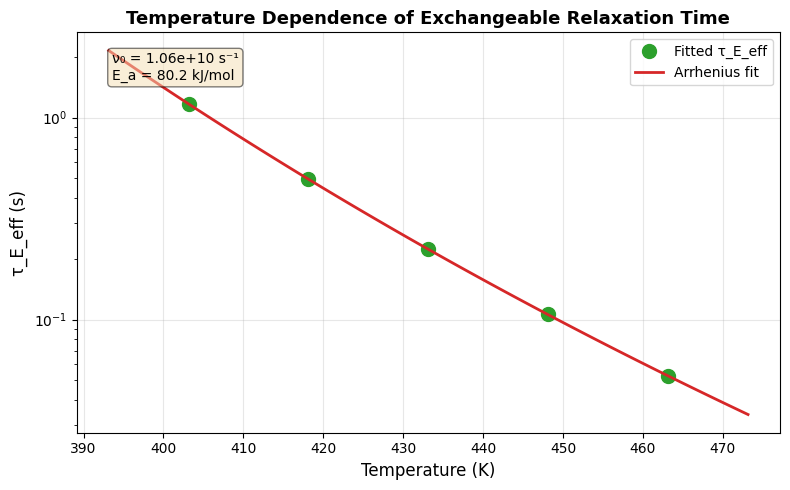

Figure saved: /Users/b80985/Projects/rheojax/examples/outputs/hvm/saos/figures/temperature_series_arrhenius.png

Arrhenius fit parameters:
  ν₀ = 1.062e+10 s⁻¹
  E_a = 80.23 kJ/mol


In [18]:
# Arrhenius plot for temperature series
fig, ax = plt.subplots(figsize=(8, 5))

ax.semilogy(T_kelvin_arr, tau_E_eff_arr, 'o', markersize=10, color='C2', label='Fitted τ_E_eff')

# Fit Arrhenius equation
from scipy.optimize import curve_fit


def arrhenius(T, nu_0_fit, E_a_fit):
    return 1 / (2 * nu_0_fit * np.exp(-E_a_fit / (R * T)))

popt, _ = curve_fit(arrhenius, T_kelvin_arr, tau_E_eff_arr, p0=[1e10, 80e3])
nu_0_fit, E_a_fit = popt

T_fit = np.linspace(T_kelvin_arr.min() - 10, T_kelvin_arr.max() + 10, 100)
tau_fit = arrhenius(T_fit, nu_0_fit, E_a_fit)
ax.semilogy(T_fit, tau_fit, '-', linewidth=2, color='C3', label='Arrhenius fit')

ax.set_xlabel("Temperature (K)", fontsize=12)
ax.set_ylabel("τ_E_eff (s)", fontsize=12)
ax.set_title("Temperature Dependence of Exchangeable Relaxation Time", fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Add text box with fitted parameters
textstr = f"ν₀ = {nu_0_fit:.2e} s⁻¹\nE_a = {E_a_fit/1e3:.1f} kJ/mol"
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
display(fig)
save_figure(fig, output_dir, "temperature_series_arrhenius.png")
plt.close(fig)

print(f"\nArrhenius fit parameters:")
print(f"  ν₀ = {nu_0_fit:.4g} s⁻¹")
print(f"  E_a = {E_a_fit/1e3:.2f} kJ/mol")

## 8. Save Results

Save fitted parameters, posterior samples, and metadata for reproducibility.

In [19]:
# Save main results
save_results(
    output_dir,
    model=model,
    result=result,
    param_names=param_names,
    extra_meta={"test_mode": "oscillation", "r_squared": r_squared},
)

print(f"\nResults saved to: {output_dir}")
print("Files:")
print("  - fitted_params_nlsq.json")
print("  - posterior_samples.npz")
print("  - summary.csv")
print("  - All figures (.png)")

Results saved to /Users/b80985/Projects/rheojax/examples/outputs/hvm/saos/

Results saved to: /Users/b80985/Projects/rheojax/examples/outputs/hvm/saos
Files:
  - fitted_params_nlsq.json
  - posterior_samples.npz
  - summary.csv
  - All figures (.png)


## Summary

**Workflow completed:**
1. Loaded Epstein SAOS data ($G'$, $G''$ vs $\omega$)
2. NLSQ fit with R² > 0.99
3. NumPyro NUTS with convergence diagnostics
4. Posterior predictive validation
5. Temperature series analysis (Arrhenius validation)
6. Results saved for reproducibility

**Key findings:**
- HVM captures two Maxwell modes: $\tau_E$ (exchangeable) and $\tau_D$ (dissociative)
- High-frequency plateau from $G_P$ (permanent crosslinks)
- Arrhenius temperature dependence validated: $k_{BER}(T) = \nu_0 \exp(-E_a/RT)$
- All convergence diagnostics passed (R-hat < 1.01, ESS > 400)

## Further Reading

**Handbook Documentation:**
- [HVM Model Reference](../../docs/source/models/hvm/hvm.rst) — Analytical SAOS expressions, two-mode spectrum, factor-of-2
- [HVM Knowledge Extraction](../../docs/source/models/hvm/hvm_knowledge.rst) — SAOS as step 1 in multi-protocol fitting, parameter identifiability
- [HVM Advanced Theory](../../docs/source/models/hvm/hvm_advanced.rst) — Helmholtz free energy, thermodynamic consistency

**References:**
1. Vernerey, F.J., Long, R. & Brighenti, R. (2017). A statistically-based continuum theory for polymers with transient networks. *J. Mech. Phys. Solids*, 107, 1-20.
2. Epstein, S. et al. (2019). Dynamic covalent chemistry and recyclable vitrimers. *Nature Reviews Chemistry*, 3, 618-631.
3. Montarnal, D. et al. (2011). Silica-like malleable materials from permanent organic networks. *Science*, 334, 965-968.

## Next Notebooks

- **Notebook 13**: LAOS Harmonic Analysis (nonlinear oscillatory response)
- **Notebook 01-06**: Basic protocol tutorials for deeper physical understanding